# Testing VGG16 network

In this notebook I use the data explored and processed in notebooks 1-3 to see how well the pretrained VGG16 model works as a classifier.

In [52]:
import os
import time
import pickle

import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import metrics

#TODO implement this function
from cars_utils import time_save_model, plot_metrics

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### BASIC  IMAGE, AND BATCH SETUP

In [57]:
# Image dimensions:
IMG_WIDTH, IMG_HEIGHT = 100*2, 75*2

BASE = os.getcwd()
SAVE_DIR = os.path.join(BASE, 'data', 'VGG16Av2')
BASE = os.path.join(BASE, 'data', 'cars_dataset', 'keras')

### Settings for full training
# TRAIN_DATA_DIR = os.path.join(BASE, 'train')
# VALIDATION_DATA_DIR = os.path.join(BASE, 'validation')
# NB_CLASSES = 196
# NB_TRAIN_SAMPLES = 11329
# NB_VALIDATION_SAMPLES = 2428
# BATCH_SIZE = 64

### Settings for fast checking
# TRAIN_DATA_DIR = os.path.join(BASE, 'fast', 'train')
# VALIDATION_DATA_DIR = os.path.join(BASE, 'fast', 'validation')
# NB_CLASSES = 196
# NB_TRAIN_SAMPLES = NB_CLASSES*2
# NB_VALIDATION_SAMPLES = NB_CLASSES
# BATCH_SIZE = 4

### Settings for faster checking
TRAIN_DATA_DIR = os.path.join(BASE, 'fast_v2', 'train')
VALIDATION_DATA_DIR = os.path.join(BASE, 'fast_v2', 'validation')
NB_CLASSES = 6
NB_TRAIN_SAMPLES = NB_CLASSES*2
NB_VALIDATION_SAMPLES = NB_CLASSES
BATCH_SIZE = 4

if K.image_data_format() == 'channels_first':
    INPUT_SHAPE = (3, IMG_WIDTH, IMG_HEIGHT)
else:
    INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [58]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=INPUT_SHAPE)

In [59]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512*4, activation='relu'))
model.add(Dense(512*4, activation='relu'))
model.add(Dense(NB_CLASSES, activation='softmax'))

conv_base.trainable = True
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 32
This is the number of trainable weights after freezing the conv base: 6


In [60]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1/255)

In [61]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 12 images belonging to 6 classes.
Found 6 images belonging to 6 classes.


Define custom metrics to measure

In [62]:
def top_3_acc(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

In [63]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[metrics.categorical_accuracy, top_3_acc])

In [65]:
EPOCHS = 5
start_time = time.time()
summary = model.fit_generator(
    train_generator,
    steps_per_epoch=NB_TRAIN_SAMPLES // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=NB_VALIDATION_SAMPLES // BATCH_SIZE)
end_time = time.time()

Epoch 1/5
3/3 [==============================] - 19s 6s/step - loss: 10.4968 - categorical_accuracy: 0.0833 - top_3_acc: 0.5000 - val_loss: 1.7953 - val_categorical_accuracy: 0.0000e+00 - val_top_3_acc: 0.2500
Epoch 2/5
3/3 [==============================] - 18s 6s/step - loss: 6.5661 - categorical_accuracy: 0.0833 - top_3_acc: 0.5000 - val_loss: 12.0886 - val_categorical_accuracy: 0.2500 - val_top_3_acc: 1.0000
Epoch 3/5
3/3 [==============================] - 18s 6s/step - loss: 13.4317 - categorical_accuracy: 0.1667 - top_3_acc: 1.0000 - val_loss: 16.1181 - val_categorical_accuracy: 0.0000e+00 - val_top_3_acc: 1.0000
Epoch 4/5
3/3 [==============================] - 21s 7s/step - loss: 13.4317 - categorical_accuracy: 0.1667 - top_3_acc: 1.0000 - val_loss: 16.1181 - val_categorical_accuracy: 0.0000e+00 - val_top_3_acc: 1.0000
Epoch 5/5
3/3 [==============================] - 21s 7s/step - loss: 13.4317 - categorical_accuracy: 0.1667 - top_3_acc: 1.0000 - val_loss: 12.0886 - val_categori

In [66]:
time_save_model(model,
                summary.history,
                start_time, end_time,
                'test',
                SAVE_DIR)

traing took: 2.0 minutes


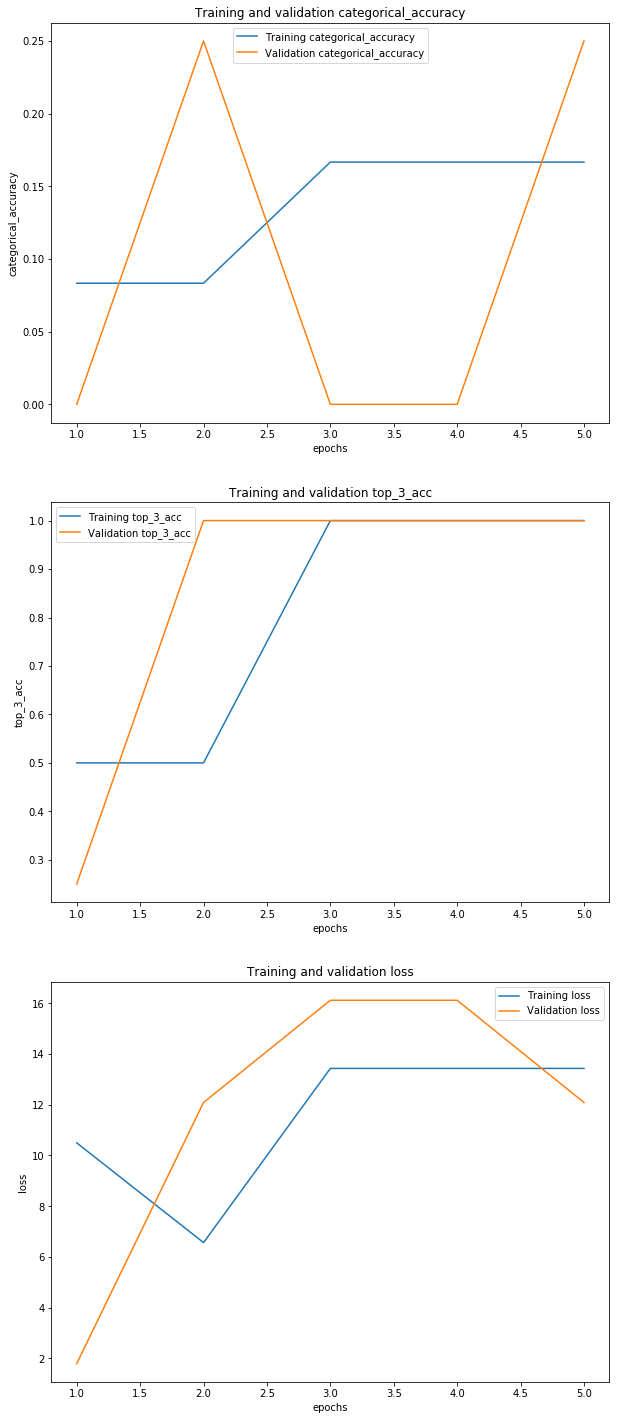

In [69]:
key_list = ['categorical_accuracy',
            'top_3_acc',
            'loss']
plot_metrics(summary.history, key_list)